# 노무현 대통령 vs 이명박 대통령 

### 필요 Library 

In [95]:
import president # Analytics Module for presidents
import pandas as pd
import re
import wordhandle # Handling TDM  & WordCount 
import numpy as np
import matplotlib.pyplot as plt # for basic plots
import seaborn as sns # for nicer plots
import json
import networkx
from konlpy.tag import Komoran
from sklearn.feature_extraction.text import CountVectorizer

from matplotlib import font_manager, rc
rc('font', family='HYsanB')  # 한글 폰트 설정

In [3]:
%matplotlib inline

## Crawling, 대통령 기록실 
 - http://www.pa.go.kr/research/contents/speech/index.jsp
 - <a href="https://github.com/byungjun0689/DataScience/blob/master/4.%20KMU/Third%20Semester/03.%20Text%20Mining%20(2017)/Project2/president.py">크롤링 코드  </a>
 - <a href="https://github.com/byungjun0689/DataScience/blob/master/4.%20KMU/Third%20Semester/03.%20Text%20Mining%20(2017)/Project2/wordhandle.py">wordhandle코드 </a>

In [4]:
# 노무현
#no_pre = president.get_president_speech("노무현")
#no_pre = president.get_speech_view_list(no_pre,"노무현")

# 이명박
#lee_pre = president.get_president_speech("이명박")
#lee_pre = president.get_speech_view_list(lee_pre, "이명박")

In [5]:
no_pre  = pd.read_csv('data/노무현_contents.csv')
lee_pre = pd.read_csv('data/이명박_contents.csv')

In [6]:
no_pre.head(2)

,category,date,href,number,president,sub_category,title,contents
0,국정전반,2003.02.25,?spMode=view&catid=c_pa02062&artid=1309347,780,노무현,취임사,제16 대 대통령 취임사,\r\r\n\t\t\t\t\t\t존경하는 국민 여러분.오늘 저는 대한민국의 제16대...
1,국정전반,2003.02.25,?spMode=view&catid=c_pa02062&artid=1309348,779,노무현,취임사,제16 대 대통령 취임 경축연 연설,"\r\r\n\t\t\t\t\t\t주한외교사절 여러분, 그리고 멀리서 오신 외빈 여러..."


In [7]:
lee_pre.head(2)

,category,date,href,number,president,sub_category,title,contents
0,국정전반,2008.02.25,?spMode=view&catid=c_pa02062&artid=1310127,819,이명박,취임사,제17 대 대통령 취임사,\r\r\n\t\t\t\t\t\t존경하는 국민 여러분!700만 해외동포 여러분!이 ...
1,국방,2008.02.28,?spMode=view&catid=c_pa02062&artid=1310128,818,이명박,치사,학군사관후보생 제46기 임관식 축사,\r\r\n\t\t\t\t\t\t학군 46기 장교 여러분!오늘 자랑스러운 소위 계급...


In [8]:
## 상위 카테고리 
cate_list = president.get_speech_category(no_pre)
cate_list

array(['국정전반', '국방', '정치/사회', '기타', '교육', '산업/경제', '과학기술/정보', '문화/체육/관광',
       '외교/통상', '환경'], dtype=object)

In [9]:
## 하위 카테고리 
sub_cate_list = president.get_speech_subcategory(no_pre)
sub_cate_list

array(['취임사', '치사', '기념사', '기타', '국회연설', '만찬사', '성명/담화문', '신년사', '환영사'], dtype=object)

### 각 연설문 카테고리별 횟수 

In [10]:
no_speech_cnt =  pd.DataFrame({'no_cnt':no_pre.groupby(['category']).size()}).reset_index().sort_values(by='no_cnt',ascending=False)
lee_speech_cnt = pd.DataFrame({'lee_cnt':lee_pre.groupby(['category']).size()}).reset_index().sort_values(by='lee_cnt',ascending=False)

 - 전체 연설에 대해서는 비슷한 비율로 연설을 하였다.
  - 비율적으로 노무현 대통령은 외교, 통상과 산업,경제 부분에서 많은 비율을 차지 했다.
  - 이명박 대통령은 상대적으로 노무현 대통령보다 문화/체육/관광의 비율이 높으며, 환경에 대한 연설횟수가 높다.

In [11]:
two_speech = pd.merge(no_speech_cnt,lee_speech_cnt)
two_speech = two_speech.append(two_speech.sum(), ignore_index=True)
two_speech.ix[10,0] = "총합"
two_speech['no_ratio'] = two_speech.apply(lambda x:round((x[1]/two_speech.ix[10,1]) * 100,2), axis=1)
two_speech['lee_ratio'] = two_speech.apply(lambda x:round((x[2]/two_speech.ix[10,2]) * 100,2), axis=1)
two_speech

,category,no_cnt,lee_cnt,no_ratio,lee_ratio
0,외교/통상,203,195,26.03,24.38
1,문화/체육/관광,124,161,15.90,20.12
2,산업/경제,114,91,14.62,11.38
3,정치/사회,110,85,14.10,10.62
4,국정전반,95,113,12.18,14.12
5,국방,50,57,6.41,7.12
6,기타,30,28,3.85,3.50
7,과학기술/정보,27,26,3.46,3.25
8,교육,24,29,3.08,3.62
9,환경,3,15,0.38,1.88


## 각 대통령별 사용 단어 빈도.

In [12]:
tdm = np.load("data/tdm_전체_노무현.npz")
tdm = tdm['arr_0'].item()

with open("data/tdm_전체_노무현.json", encoding='utf8') as f:
    words = json.load(f)

In [13]:
tdm2 = np.load("data/tdm_전체_이명박.npz")
tdm2 = tdm2['arr_0'].item()

with open("data/tdm_전체_이명박.json", encoding='utf8') as f:
    words2 = json.load(f)

[('국민', 3177), ('생각', 2641), ('경제', 2360), ('정부', 2013), ('문제', 1816), ('사람', 1739), ('사회', 1738), ('협력', 1732), ('발전', 1646), ('한국', 1602)]


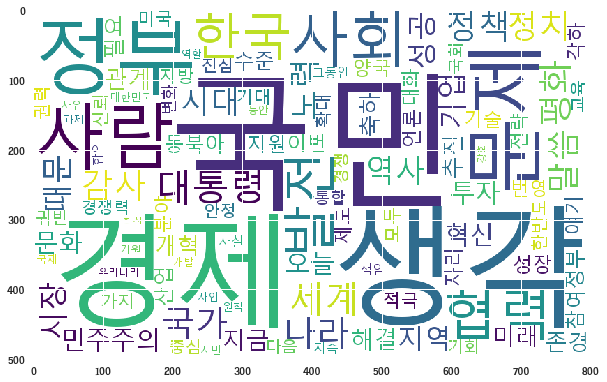

In [44]:
wordcloud = wordhandle.makeWordCloud(tdm,words)

[('국민', 3326), ('세계', 3254), ('생각', 2557), ('경제', 2041), ('나라', 2028), ('대한민국', 1975), ('한국', 1871), ('정부', 1869), ('국가', 1695), ('사회', 1646)]


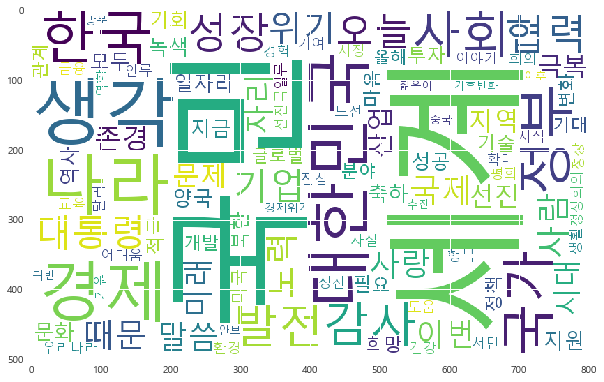

In [15]:
wordcloud2 = wordhandle.makeWordCloud(tdm2, words2)

### 전체 연셜 비교 
 - WordCloud에서도 확인 할 수 있듯이 
  - 노무현 대통령 : 협력, 정부, 사람, 시대, 개혁, 민주주의, 평화, 사회 등의 단어를 상대적으로 이명박 대통령보다 많이 사용.
  - 이명박 대통령 : 나라, 발전, 경제, 글로벌, 선진, 기업 등의 단어를 상대적으로 노무현 대통령보다 많이 사용.
 - 확연히 이명박 대통령의 경우 경제와 관련된 이슈를 중요시하는 모습을 보이고 노무현 대통령은 평화 화합과 같은 민주주의를 중요시 하는 것을 알 수 있다.

In [16]:
df = president.two_wordcount_df(wordcloud,wordcloud2)

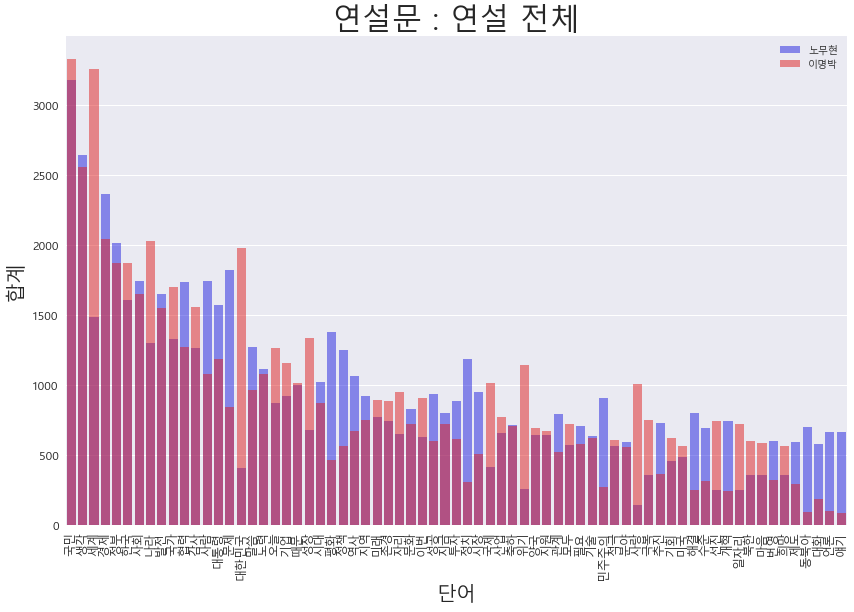

In [17]:
president.get_compare_words_view(df,"노무현","이명박","연설 전체")

### 단어별 연관 네트워크 

#### 노무현 대통령 

In [113]:
words_list = [word for word, count in wordcloud[:50]]

### 상위 100개 단어로 TDM 만들기 

In [114]:
def get_noun(text):
    tagger = Komoran() # 형태소 분석기
    nouns = tagger.nouns(text)
    return [n for n in nouns if n in words_list] # 2글자 이상만

In [115]:
cv = CountVectorizer(tokenizer=get_noun, max_features=500)

In [116]:
tdm_network = cv.fit_transform(no_pre['contents'])

In [117]:
network_words = cv.get_feature_names()

In [118]:
G = networkx.Graph()

In [119]:
word_corr_no = np.corrcoef(tdm_network.todense(), rowvar=0)

In [120]:
word_corr_no

array([[ 1.        ,  0.10561176,  0.26236516, ...,  0.32457366,
         0.10200498,  0.30169764],
       [ 0.10561176,  1.        ,  0.50666512, ...,  0.38538036,
         0.39771354,  0.05485673],
       [ 0.26236516,  0.50666512,  1.        , ...,  0.60794706,
         0.58310678,  0.38813771],
       ..., 
       [ 0.32457366,  0.38538036,  0.60794706, ...,  1.        ,
         0.34710782,  0.34939934],
       [ 0.10200498,  0.39771354,  0.58310678, ...,  0.34710782,
         1.        ,  0.04084258],
       [ 0.30169764,  0.05485673,  0.38813771, ...,  0.34939934,
         0.04084258,  1.        ]])

In [121]:
edges_no = []
for i in range(len(network_words)):
    for j in range(i+1,len(network_words)):
        edges_no.append((network_words[i],network_words[j], word_corr_no[i,j]))

In [122]:
edges_no = sorted(edges_no,key=lambda x:x[2], reverse=True)

In [123]:
edge_no_list = [(word1, word2) for word1, word2, weight in edges_no]
weight_no_list = [weight for word1, word2, weight in edges_no]

In [124]:
edge_no_set = set()
for word1, word2, weight in edges_no:
    G.add_edge(word1, word2, weight=weight)
    edge_no_set.add((word1,word2))

(-0.07693350068763663, 0.8096335072365568, -0.10500000000000001, 1.105)

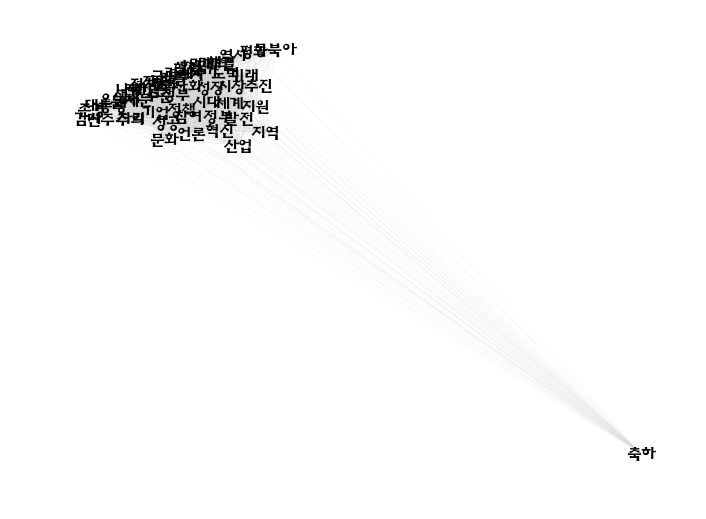

In [125]:
position = networkx.spring_layout(G, k=0.09,  iterations=100)
plt.figure(figsize=(12, 9))
networkx.draw_networkx_nodes(G, position, node_size=0)
networkx.draw_networkx_edges(G, position, edgelist=edge_no_list, width=weight_no_list, edge_color='lightgray')
networkx.draw_networkx_labels(G, position, font_size=15,font_family='HYsanB')
plt.axis('off')

## 영역별 비교 

### 1. 취임사 

In [17]:
tdm = np.load("data/tdm_취임사_노무현.npz")
tdm = tdm['arr_0'].item()

with open('data/tdm_취임사_노무현_.json', encoding='utf8') as f:
    words = json.load(f)

In [18]:
tdm2 = np.load("data/tdm_취임사_이명박.npz")
tdm2 = tdm2['arr_0'].item()

with open('data/tdm_취임사_이명박_.json', encoding='utf8') as f:
    words2 = json.load(f)

[('국민', 29), ('평화', 20), ('동북아', 19), ('사회', 18), ('시대', 16), ('세계', 14), ('한반도', 12), ('경제', 10), ('발전', 10), ('대화', 9)]


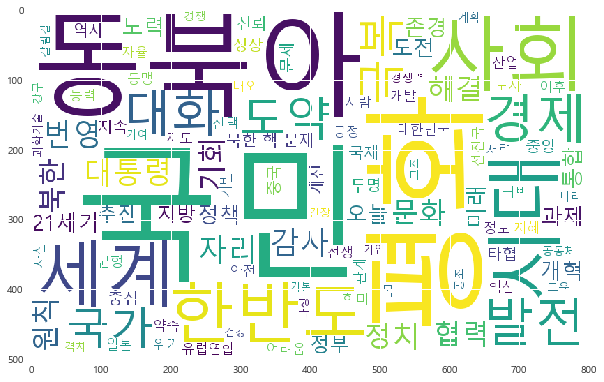

In [19]:
wordcount = wordhandle.makeWordCloud(tdm,words)

[('국민', 30), ('나라', 21), ('사회', 18), ('세계', 16), ('대한민국', 15), ('정부', 14), ('선진', 12), ('경제', 11), ('문화', 11), ('존경', 11)]


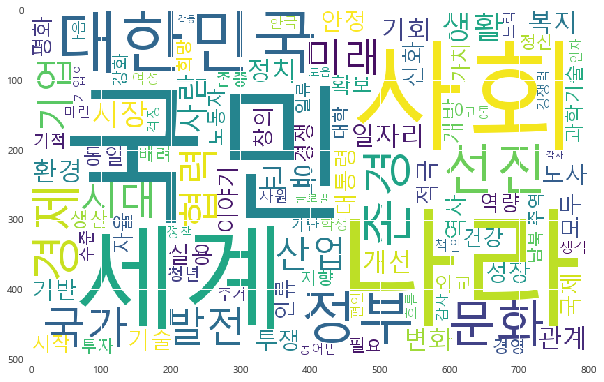

In [20]:
wordcount2 = wordhandle.makeWordCloud(tdm2,words2)

In [21]:
df = president.two_wordcount_df(wordcount,wordcount2)

#### 연설비교 
 - 이명박 대통령 : 나라의 역할 나라, 정부의 주도의 행동을 강조하는 듯하는 모습을 보인다.
 - 노무현 대통령 : 대한민국, 정부 단어 언급보다는 시대적,평화 등 한번도 평화에 대한 언급이 많았다. <br>대화, 지리 등 한반도 정세에 대한 언급이 많다.

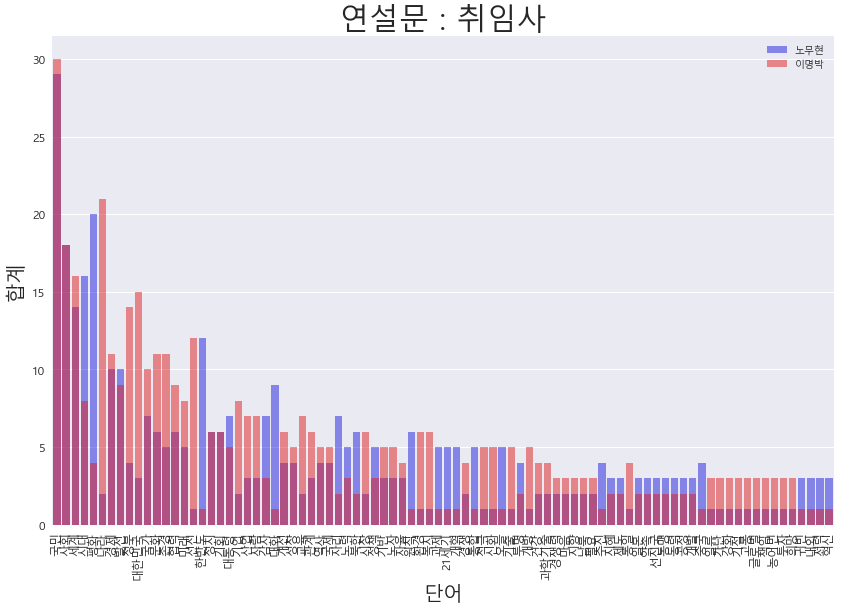

In [22]:
president.get_compare_words_view(df,"노무현","이명박","취임사")

### 2. 교육 

In [23]:
tdm = np.load("data/tdm_교육_노무현.npz")
tdm = tdm['arr_0'].item()

with open('data/tdm_교육_노무현.json', encoding='utf8') as f:
    words = json.load(f)    

tdm2 = np.load("data/tdm_교육_이명박.npz")
tdm2 = tdm2['arr_0'].item()

with open('data/tdm_교육_이명박.json', encoding='utf8') as f:
    words2 = json.load(f)

### 2.1 WordCloud를 통한 교육 지향점 비교 
 - 노무현 대통령 : 사회, 사람, 국민, 생각, 정부 제도, 혁신 등의 단어를 많이 언급.

[('사람', 127), ('교육', 120), ('사회', 120), ('생각', 91), ('대학', 76), ('학생', 65), ('국민', 62), ('성공', 57), ('세계', 53), ('문제', 51)]


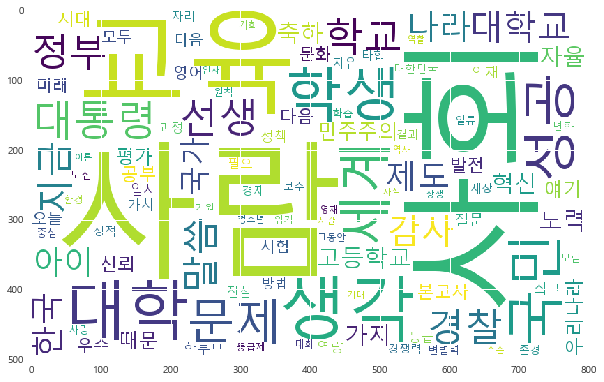

In [24]:
wordcount = wordhandle.makeWordCloud(tdm,words)

 - 이명박 대통령 : 비교적으로 인재, 발전, 세계 등의 단어를 많이 사용.

[('교육', 128), ('세계', 85), ('학생', 77), ('생각', 76), ('인재', 71), ('학교', 70), ('감사', 57), ('정부', 54), ('사회', 52), ('발전', 47)]


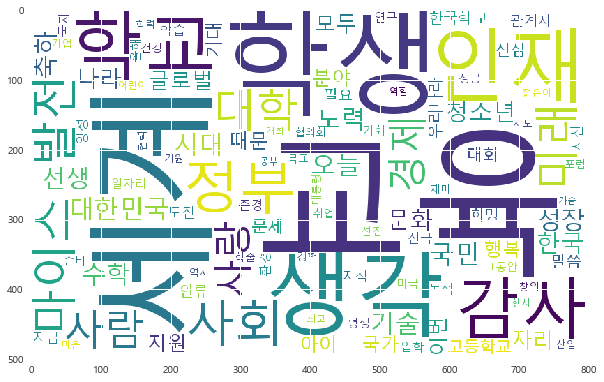

In [25]:
wordcount2 = wordhandle.makeWordCloud(tdm2,words2)

In [26]:
df = president.two_wordcount_df(wordcount, wordcount2)

### 2.2 교육 연설문 직접 비교.
 - 노무현 대통령 : 사람, 사회, 문제점, 평가, 경쟁 등의 현재 문제점을 지적하는 부분이 많은 것으로 판단이 되며 제도 개선이 필요하다는 얘기를 많이 하는 것으로 보인다.
 - 이명박 대통령 : 인재, 나라, 성장, 글로벌, 세계 등 경제적인 발전 또는 개인의 발전을 통해 나라를 부흥 할 수 있는 방안 등을 언급 한것으로 판단되는 단어들을 많이 사용. 

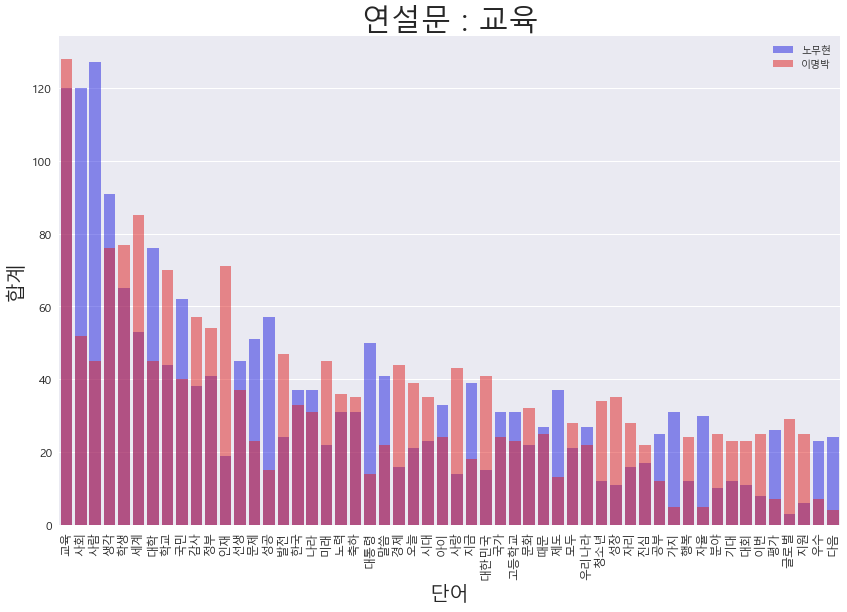

In [27]:
president.get_compare_words_view(df,"노무현","이명박","교육")

### 2.3 주제 파악 
#### 2.3.1 노무현 대통령 

In [28]:
lda, topics = president.get_lda_topic(tdm,words,20) # tdm, words, Number of topics
topics[:5] # 3번, 9번, 18번 정도의 토픽이 대부분을 차지한다. 

[(3, 6.1678374914180987),
 (9, 2.7466242459812364),
 (18, 2.4691254810261203),
 (19, 1.9754364290323023),
 (8, 1.9447555127888387)]

In [29]:
lda.show_topic(3) # 아래와 같은 주제를 교육 관련 연설에서 높은 비율로 연설하였음.

[('대학', 0.032646599970350465),
 ('교육', 0.029293843973898819),
 ('사회', 0.029052041912780435),
 ('선생', 0.023034819138586706),
 ('세계', 0.016392872539000777),
 ('생각', 0.012651907273886213),
 ('학생', 0.012471118027299333),
 ('학교', 0.012414928304828876),
 ('성공', 0.011425590535281851),
 ('발전', 0.011412745012211975)]

In [30]:
lda.show_topic(9) # 재외동포교육 국제학술대회, 경찰 졸업생 축하 연설관련.

[('국민', 0.029802491118632955),
 ('경찰', 0.02899437901182397),
 ('사회', 0.022387446569912074),
 ('재외동포', 0.01560308539933143),
 ('선생', 0.01466984793618374),
 ('교육', 0.01450017363008058),
 ('사람', 0.012913433364506321),
 ('감사', 0.012792438339246976),
 ('대회', 0.012524166399410543),
 ('세계', 0.011019198208913417)]

#### 2.3.2 이명박 대통령

In [31]:
lda2, topics2 = president.get_lda_topic(tdm2,words2,20) # tdm, words, Number of topics
topics2[:5]  # 6번 하나의 주제로 모든 연설에서 했다고 봐도 무방하다.

[(6, 12.107081024727949),
 (19, 2.5052782362806636),
 (2, 2.3039492760984208),
 (3, 1.8874289721778639),
 (4, 1.6221853793131871)]

In [32]:
lda.show_topic(6)

[('사람', 0.026207804071926966),
 ('사회', 0.024771881752205436),
 ('생각', 0.022428023208096053),
 ('교육', 0.017431494565367064),
 ('대학', 0.01580942749092595),
 ('학생', 0.012818267961131728),
 ('문제', 0.011111147538716427),
 ('대통령', 0.010952867688866613),
 ('세계', 0.010947429338905912),
 ('말씀', 0.010931025971276421)]

### 3. 외교 

In [33]:
tdm = np.load("data/tdm_외교_노무현.npz")
tdm = tdm['arr_0'].item()

with open('data/tdm_외교_노무현_.json', encoding='utf8') as f:
    words = json.load(f)
    
tdm2 = np.load("data/tdm_외교_이명박.npz")
tdm2 = tdm2['arr_0'].item()

with open('data/tdm_외교_이명박_.json', encoding='utf8') as f:
    words2 = json.load(f)

### 3.1 WordCloud를 통한 외교 지향점

[('협력', 1050), ('한국', 831), ('경제', 705), ('각하', 638), ('양국', 591), ('국민', 518), ('나라', 505), ('평화', 492), ('발전', 482), ('생각', 470)]


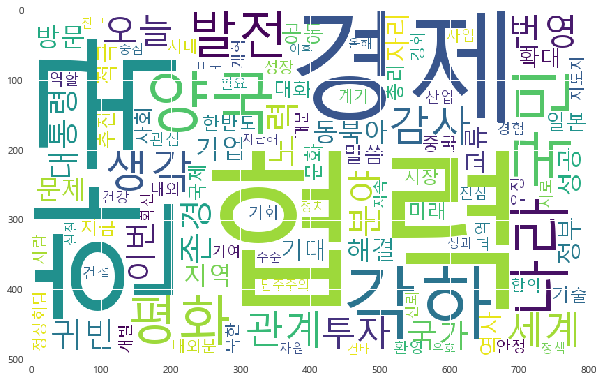

In [34]:
wordcount = wordhandle.makeWordCloud(tdm,words)

[('한국', 1094), ('세계', 882), ('협력', 870), ('생각', 778), ('경제', 703), ('양국', 636), ('나라', 596), ('국민', 555), ('대한민국', 553), ('발전', 536)]


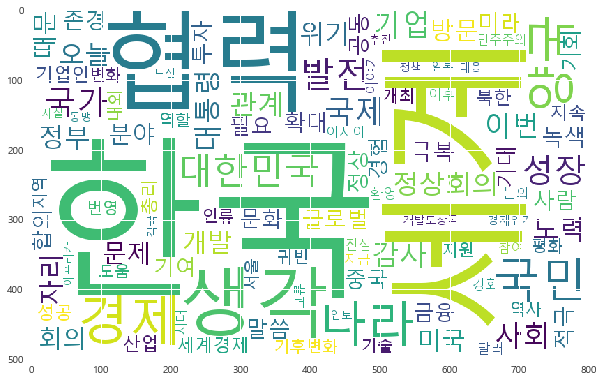

In [35]:
wordcount2 = wordhandle.makeWordCloud(tdm2,words2)

In [36]:
df = president.two_wordcount_df(wordcount,wordcount2)

 - 노무현 대통령 : 외교 관련 연설문 처음에 존경하는 XXX 각하 라는 표현을 많이 하여 각하라는 말이 많이 나왔다. 상대적으로 평화 번영, 동북아 정세에 관련하여 많은 언급을 한 것으로 파악된다.
 - 이명박 대통령 : 차이가 많이 나는 단어들이 많이 존재한다. 국제, 세계경제, 세계, 성장, 사회, 정상회의 극복 등 세계경제에서의 극복과제와 발전 등 지금까지와 일관성있는 경제 부분만 언급하고 있는 것으로 보인다.

#### 2.2 국회연설문 직접 비교.

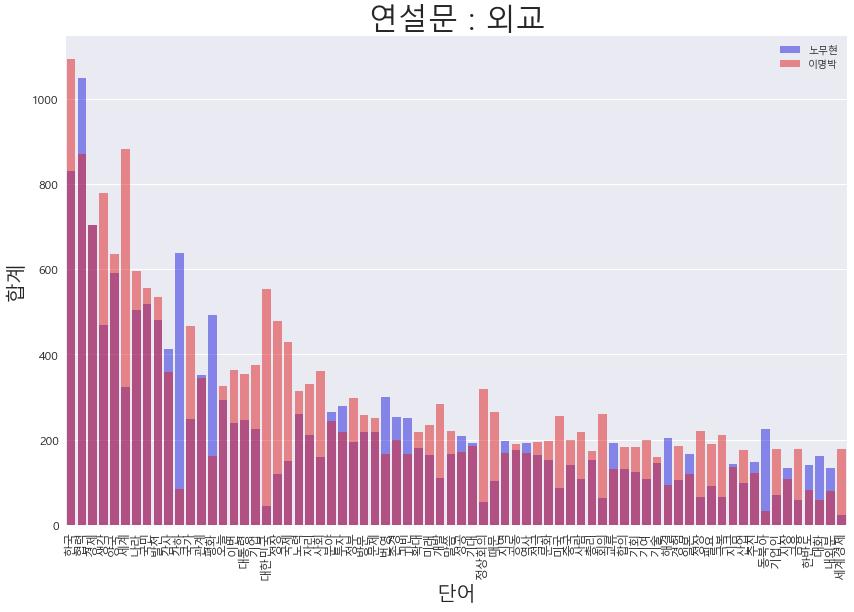

In [37]:
president.get_compare_words_view(df,"노무현","이명박","외교")

### 3.3 주제파악 
#### 3.3.1 노무현 대통령 

In [47]:
lda, topics = president.get_lda_topic(tdm,words,5) # tdm, words, Number of topics
topics # 1,2,4,0이 대부분을 이룬다.

[(1, 65.76528624700218),
 (2, 61.543566280328534),
 (4, 31.235916423224008),
 (0, 30.639709368251857),
 (3, 12.632875420193342)]

In [48]:
lda.show_topic(1) # 양국과의 평화 발전 협력 등을 말하는...당연한 거아닌가..?

[('협력', 0.028368473966681327),
 ('한국', 0.024298807989057321),
 ('양국', 0.023985937173642877),
 ('각하', 0.021095701420221023),
 ('국민', 0.016385166136828885),
 ('평화', 0.016052091795164255),
 ('감사', 0.015283818326493611),
 ('경제', 0.014665907182787333),
 ('나라', 0.014540560279906092),
 ('발전', 0.013795597418646404)]

#### 3.3.2 이명박 대통령 

In [52]:
lda2, topics2 = president.get_lda_topic(tdm2,words2,10) # tdm, words, Number of topics
topics2 # 1,3,5,0 정도가 대부분이다.

[(1, 48.868578403259384),
 (3, 28.860720808292179),
 (5, 23.396032882063935),
 (0, 22.784467679325925),
 (8, 18.979418690744524),
 (4, 15.394549150337298),
 (2, 14.460849260256959),
 (6, 11.57572263699204),
 (9, 5.8831647934248936),
 (7, 3.5935457446002874)]

In [53]:
lda2.show_topic(1) # 워낙 비슷하다. 외교적으로는 비슷한 주제를 언급하고 있다고 생각된다.

[('한국', 0.028869216306058189),
 ('협력', 0.021523118498629919),
 ('생각', 0.019652754024231806),
 ('경제', 0.019311409594087749),
 ('양국', 0.016859724071481445),
 ('세계', 0.0165302802280137),
 ('발전', 0.015007544490262995),
 ('국민', 0.013536332215126751),
 ('나라', 0.013508175015670953),
 ('대한민국', 0.013331023429703199)]

### 4. 국회연설 

In [54]:
#tdm, cv = president.get_president_sub_tdm(no_pre,"국회연설",500)
#tdm2, cv2 = president.get_president_sub_tdm(lee_pre,"국회연설",500)

In [57]:
tdm = np.load("data/tdm_국회연설_노무현.npz")
tdm = tdm['arr_0'].item()

with open('data/tdm_국회연설_노무현.json', encoding='utf8') as f:
    words = json.load(f)
    
tdm2 = np.load("data/tdm_국회연설_이명박.npz")
tdm2 = tdm2['arr_0'].item()

with open('data/tdm_국회연설_이명박.json', encoding='utf8') as f:
    words2 = json.load(f)

### 4.1 WordCloud를 통한 국회연설 비교

#### 4.1.1 노무현 대통령
 - 국회를 향해 국민을 향한 정부의 지원과 추진, 확대, 투자 등을 의원들에게 호소하는 연설문이 많다.

[('국민', 191), ('정부', 187), ('경제', 150), ('사회', 122), ('지원', 116), ('추진', 98), ('확대', 97), ('국가', 94), ('투자', 92), ('의원', 91)]


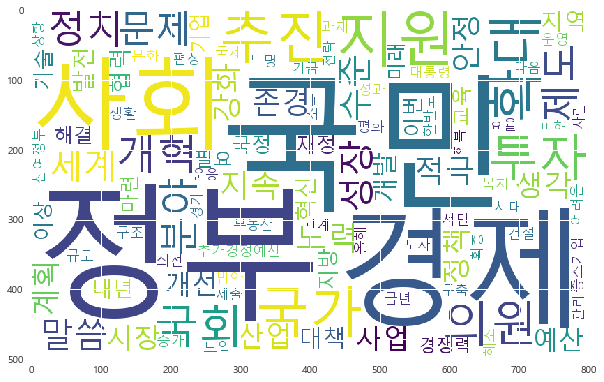

In [58]:
wordcount = wordhandle.makeWordCloud(tdm,words)

#### 4.1.2 이명박 대통령
 - 경제 성장, 세계 경제 위기, 발전, 국회의 역할 등 산업에 대한 성장 극복, 발전 등에 대한 내용이 많다.

[('정부', 182), ('국민', 171), ('경제', 146), ('세계', 139), ('위기', 107), ('사회', 96), ('성장', 96), ('국가', 84), ('국회', 78), ('발전', 74)]


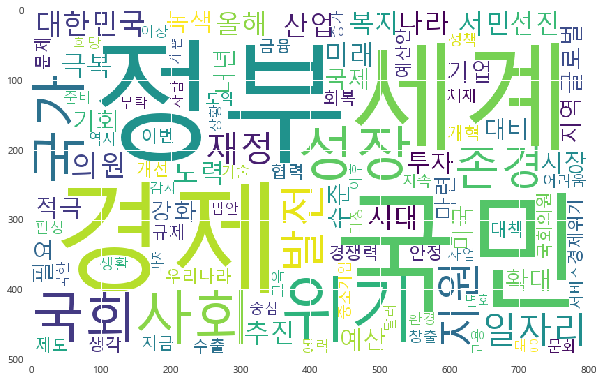

In [59]:
wordcount2 = wordhandle.makeWordCloud(tdm2,words2)

In [60]:
df = president.two_wordcount_df(wordcount,wordcount2)

#### 4.2 국회연설 직접 비교 
 - 위에 언급한 내용과 같이 
  - 노무현 대통령 : 추진, 확대, 투자, 제도, 강화, 개발, 국정, 지원 등의 내용을 많이 언급한 반면
  - 이명박 대통령 : 위기, 사회, 투자, 일자리, 미래, 극복, 선진 국가, 미국 등 경제 발전에 대한 언급이 많다. 

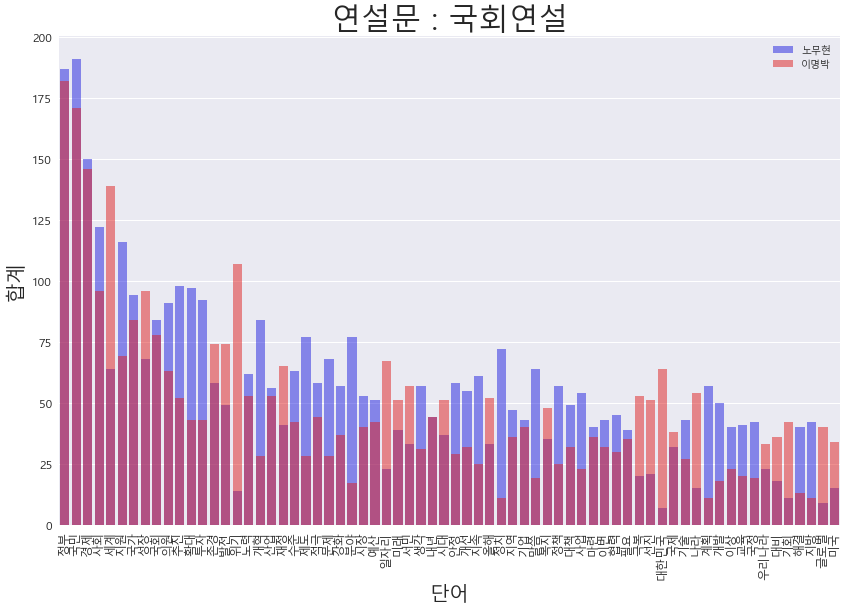

In [61]:
president.get_compare_words_view(df,"노무현","이명박","국회연설")